2023-07-27 13:48:55.740539: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

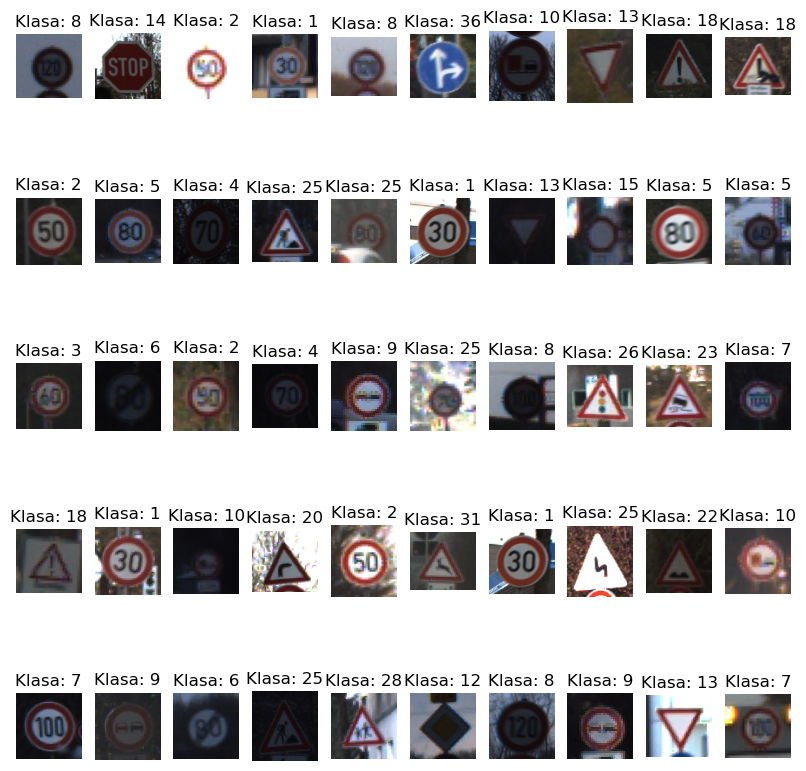

Matrica e Konfuzionit:
[[ 67 713 723 ...  80  59  94]
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Përcaktimi i shtegut të datasetit
dataset_path = 'gtsrb-dataset'

# Ngarkimi i skedarit CSV të trajnimit
train_data = pd.read_csv(os.path.join(dataset_path, 'Train.csv'))

# Ngarkimi dhe përpunimi i imazheve të trajnimit
train_images = []
train_labels = []
for i, row in train_data.iterrows():
    image_path = os.path.join(dataset_path, row['Path'])
    image = Image.open(image_path)
    image = image.resize((32, 32))
    image_array = np.array(image)
    train_images.append(image_array)
    train_labels.append(row['ClassId'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Kryerja e kodimit one-hot për etiketat e trajnimit
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)

# Krijimi i modelit të rrjetit neural konvolucional
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(43, activation='softmax')
])

# Kompilimi i modelit
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printimi i përmbledhjes së modelit
model.summary()

# Trajnimi i modelit me të dhënat e trajnimit
model.fit(train_images, train_labels, epochs=10, batch_size=32)

# Klasifikimi i imazheve në folderin e testimit
test_images = []
test_labels = []
test_image_paths = []
test_folder_path = os.path.join(dataset_path, 'Test')
for filename in os.listdir(test_folder_path):
    image_path = os.path.join(test_folder_path, filename)
    if image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        try:
            image = Image.open(image_path)
            image = image.resize((32, 32))
            image_array = np.array(image)
            test_images.append(image_array)
            test_image_paths.append(image_path)
            test_labels.append(int(filename.split('.')[0]))  # Ekstraktimi i klasës së vërtetë nga emri i skedarit "<class_id>.extension"
        except (IOError, OSError):
            print(f"Nuk mund të hapet ose përpunohet {image_path}")

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Bërja e parashikimeve mbi imazhet e testimit
predictions = model.predict(test_images)

# Kthimi i klasave të parashikuara në stringje të lexueshme
predicted_labels = label_binarizer.inverse_transform(predictions)

# Kthimi i etiketave të testimit në formatin one-hot encoded
test_labels = label_binarizer.transform(test_labels)

# Vlerësimi i modelit në setin e testimit
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Humbja në testim: {test_loss:.4f}')
print(f'Saktesia në testim: {test_accuracy:.4f}')

# Shfaqja e imazheve me etiketat e parashikuara
fig, axes = plt.subplots(5, 10, figsize=(10, 10))
axes = axes.ravel()

for i in range(min(50, len(test_image_paths))):
    image = Image.open(test_image_paths[i])
    axes[i].imshow(image)
    axes[i].set_title(f"Klasa: {predicted_labels[i]}")
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

# Llogaritja e matricës së konfuzionit
cm = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

print("Matrica e Konfuzionit:")
print(cm)
